In [1]:
# load packages required for analysis
#install.packages("")
#BiocManager::install("")

# load packages required for analysis
library("clusterProfiler")
library("org.Hs.eg.db")
library("ReactomePA")

#library(tidyverse)
#library(splitstackshape)
library("RColorBrewer")
library("pheatmap")

# note reactome database version
BiocManager::version()
reactome.db::reactome.db

print("packages loaded")



clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:stats’:

    filter


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, p

[1] ‘3.16’


Please see: help('select') for usage information



ReactomeDb object:
| DBSCHEMA: REACTOME_DB
| DBSCHEMAVERSION: 82
| SOURCENAME: Reactome
| SOURCEURL: http://www.reactome.org/download/current/
| SOURCEDATE: 2022-10-04
| Supporting package: AnnotationDbi
| Db type: ReactomeDb

[1] "packages loaded"


In [2]:
### import necessary variables
project_master_dir = "/stg3/data2/resource3/project/RA-TIP-CS"

version_dir = "/YesSNPqc_Female_Allchrom"
#version_dir = "/YesSNPqc_Female_Allchrom"

## input
# Union of clinical status
dmgUnion_v1_bCell_F_DMG_fp = paste0(project_master_dir, "/Analysis", version_dir, "/DMGs", "/dmgUnion_v1_bCell_F_allChrom_vector.csv") # Female only, All Chrom, yes SNP QC filtering
dmgUnion_v1_tMem_F_DMG_fp = paste0(project_master_dir, "/Analysis", version_dir, "/DMGs", "/dmgUnion_v1_tMem_F_allChrom_vector.csv") # Female only, All Chrom, yes SNP QC filtering
dmgUnion_v1_tNai_F_DMG_fp = paste0(project_master_dir, "/Analysis", version_dir, "/DMGs", "/dmgUnion_v1_tNai_F_allChrom_vector.csv") # Female only, All Chrom, yes SNP QC filtering

# ccpPvccpM only
dmgUnion_v1_bCell_ccpPvccpM_F_DMG_fp = paste0(project_master_dir, "/Analysis", version_dir, "/DMGs", "/dmgUnion_v1_bCell_ccpPvccpM_F_allChrom_vector.csv")
dmgUnion_v1_tMem_ccpPvccpM_F_DMG_fp = paste0(project_master_dir, "/Analysis", version_dir, "/DMGs", "/dmgUnion_v1_tMem_ccpPvccpM_F_allChrom_vector.csv")
dmgUnion_v1_tNai_ccpPvccpM_F_DMG_fp = paste0(project_master_dir, "/Analysis", version_dir, "/DMGs", "/dmgUnion_v1_tNai_ccpPvccpM_F_allChrom_vector.csv")
          
# ccpPvera
dmgUnion_v1_bCell_ccpPvera_F_DMG_fp = paste0(project_master_dir, "/Analysis", version_dir, "/DMGs", "/dmgUnion_v1_bCell_ccpPvera_F_allChrom_vector.csv")
dmgUnion_v1_tMem_ccpPvera_F_DMG_fp = paste0(project_master_dir, "/Analysis", version_dir, "/DMGs", "/dmgUnion_v1_tMem_ccpPvera_F_allChrom_vector.csv")
dmgUnion_v1_tNai_ccpPvera_F_DMG_fp = paste0(project_master_dir, "/Analysis", version_dir, "/DMGs", "/dmgUnion_v1_tNai_ccpPvera_F_allChrom_vector.csv")

# heatmap dataframe input
dmgUnion_tMem_dmlDMGmatch_fp = paste0(project_master_dir, "/Analysis", version_dir, "/DMLs", "/dmlDMGmatch_tMem_df.csv")
dmgUnion_tMem_dmlDMGmatch_M_fp = paste0(project_master_dir, "/Analysis", version_dir, "/DMLs", "/dmlDMGmatch_M_tMem_df.csv")
                                    
## output
reactome_output_dir = paste0(project_master_dir, "/Analysis", version_dir, "/Reactome")
dir.create(file.path(reactome_output_dir), showWarnings = FALSE)

dataLog_fp = paste0(project_master_dir, "/Analysis", version_dir, "/dataLog.txt", append = TRUE)

### Set cutoffs for all
pval_max = 0.01

In [3]:
### Reactome Analysis - B Cell ###
active_dmg_fp = dmgUnion_v1_bCell_F_DMG_fp

# get DMG vector
active_dmg_vector = as.data.frame(read.delim(active_dmg_fp, row.names = NULL, header = TRUE))[,1]

# create ID map dataframe
active_dmg_IDmap_df = bitr(active_dmg_vector, "SYMBOL", "ENTREZID", OrgDb = org.Hs.eg.db)

# create enriched pathways object
active_dmg_pathways_obj = enrichPathway(gene=active_dmg_IDmap_df$ENTREZID, pAdjustMethod = "fdr")

# separate object into vectors
active_dmg_pathways_description_vector = as.vector(active_dmg_pathways_obj@result$Description)
active_dmg_pathways_pvalue_vector = as.vector(active_dmg_pathways_obj@result$pvalue)
active_dmg_pathways_adjPvalue_vector = as.vector(active_dmg_pathways_obj@result$p.adjust)

active_dmg_pathways_geneID_vector = as.vector(active_dmg_pathways_obj@result$geneID)
active_dmg_pathways_geneSymbol_vector = vector()
for (string in active_dmg_pathways_geneID_vector){
  old_string = string
  new_string = old_string
  for (id_row in 1:length(active_dmg_IDmap_df$ENTREZID)){
    id_num = active_dmg_IDmap_df[id_row,2]
    id_sym = active_dmg_IDmap_df[id_row,1]
    new_string = gsub(id_num, id_sym, new_string)
  }
  active_dmg_pathways_geneSymbol_vector = append(active_dmg_pathways_geneSymbol_vector, new_string)
}

active_dmg_pathwaysAll_df = data.frame("Description" = active_dmg_pathways_description_vector, 
                                       "P_Value" = active_dmg_pathways_pvalue_vector, 
                                       "Adj_Pval_FDR" = active_dmg_pathways_adjPvalue_vector, 
                                       "Gene Symbol" = active_dmg_pathways_geneSymbol_vector)

# create dataframe
active_dmg_pathwaysSelected_df = active_dmg_pathwaysAll_df[active_dmg_pathwaysAll_df$P_Value < pval_max,]
active_dmg_pathwaysSelected_df

# output 
setwd(reactome_output_dir)
write.table(active_dmg_pathwaysSelected_df, file="dmgUnion_v1_bCell_F_allChrom_pathways.csv", quote=FALSE, sep='\t', row.names = FALSE, col.names = TRUE)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(active_dmg_vector, "SYMBOL", "ENTREZID", OrgDb = org.Hs.eg.db):
“10.61% of input gene IDs are fail to map...”


,Description,P_Value,Adj_Pval_FDR,Gene.Symbol
,<chr>,<dbl>,<dbl>,<chr>
1,Collagen chain trimerization,7.263508e-05,0.03348477,COL13A1/COL22A1/COL4A2/COL5A3/1ABR8
2,Collagen formation,2.745430e-04,0.04963430,COL13A1/COL22A1/COL4A2/COL5A3/1ABR8/CTSB
3,Collagen degradation,4.352063e-04,0.04963430,COL13A1/COL4A2/COL5A3/1ABR8/CTSB
4,cGMP effects,4.956121e-04,0.04963430,KCNMA1/PDE9A/PRKG1
5,Collagen biosynthesis and modifying enzymes,5.383330e-04,0.04963430,COL13A1/COL22A1/COL4A2/COL5A3/1ABR8
6,NCAM1 interactions,7.907745e-04,0.06075784,CACNA1D/COL4A2/COL5A3/1ABR8
7,Nitric oxide stimulates guanylate cyclase,1.304723e-03,0.08592534,KCNMA1/PDE9A/PRKG1
8,Assembly of collagen fibrils and other multimeric structures,3.188470e-03,0.18360041,COL4A2/COL5A3/1ABR8/CTSB
9,NCAM signaling for neurite out-growth,3.584390e-03,0.18360041,CACNA1D/COL4A2/COL5A3/1ABR8


In [4]:
### Reactome Analysis - Memory T Cell ###
active_dmg_fp = dmgUnion_v1_tMem_F_DMG_fp

# get DMG vector
active_dmg_vector = as.data.frame(read.delim(active_dmg_fp, row.names = NULL, header = TRUE))[,1]

# create ID map dataframe
active_dmg_IDmap_df = bitr(active_dmg_vector, "SYMBOL", "ENTREZID", OrgDb = org.Hs.eg.db)

# create enriched pathways object
active_dmg_pathways_obj = enrichPathway(gene=active_dmg_IDmap_df$ENTREZID, pAdjustMethod = "fdr")

# separate object into vectors
active_dmg_pathways_description_vector = as.vector(active_dmg_pathways_obj@result$Description)
active_dmg_pathways_pvalue_vector = as.vector(active_dmg_pathways_obj@result$pvalue)
active_dmg_pathways_adjPvalue_vector = as.vector(active_dmg_pathways_obj@result$p.adjust)

active_dmg_pathways_geneID_vector = as.vector(active_dmg_pathways_obj@result$geneID)
active_dmg_pathways_geneSymbol_vector = vector()
for (string in active_dmg_pathways_geneID_vector){
  old_string = string
  new_string = old_string
  for (id_row in 1:length(active_dmg_IDmap_df$ENTREZID)){
    id_num = active_dmg_IDmap_df[id_row,2]
    id_sym = active_dmg_IDmap_df[id_row,1]
    new_string = gsub(id_num, id_sym, new_string)
  }
  active_dmg_pathways_geneSymbol_vector = append(active_dmg_pathways_geneSymbol_vector, new_string)
}

active_dmg_pathwaysAll_df = data.frame("Description" = active_dmg_pathways_description_vector, 
                                       "P_Value" = active_dmg_pathways_pvalue_vector, 
                                       "Adj_Pval_FDR" = active_dmg_pathways_adjPvalue_vector, 
                                       "Gene Symbol" = active_dmg_pathways_geneSymbol_vector)

# create dataframe
active_dmg_pathwaysSelected_df = active_dmg_pathwaysAll_df[active_dmg_pathwaysAll_df$P_Value < pval_max,]
active_dmg_pathwaysSelected_df

# get the DMGs that drive pathway enrichment
tMem_dmg_pathwaysSelected_df = active_dmg_pathwaysSelected_df

# output 
setwd(reactome_output_dir)
write.table(active_dmg_pathwaysSelected_df, file="dmgUnion_v1_tMem_F_allChrom_pathways.csv", quote=FALSE, sep='\t', row.names = FALSE, col.names = TRUE)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(active_dmg_vector, "SYMBOL", "ENTREZID", OrgDb = org.Hs.eg.db):
“10% of input gene IDs are fail to map...”


,Description,P_Value,Adj_Pval_FDR,Gene.Symbol
,<chr>,<dbl>,<dbl>,<chr>
1,Translocation of ZAP-70 to Immunological synapse,1.317984e-10,1.033300e-07,CD247/CD3D/CD3E/CD3G/HLA-DQB1/HLA-DQB2/HLA-DRB1/LCK
2,Phosphorylation of CD3 and TCR zeta chains,5.368655e-10,2.104513e-07,CD247/CD3D/CD3E/CD3G/HLA-DQB1/HLA-DQB2/HLA-DRB1/LCK
3,PD-1 signaling,8.128585e-10,2.124270e-07,CD247/CD3D/CD3E/CD3G/HLA-DQB1/HLA-DQB2/HLA-DRB1/LCK
4,Generation of second messenger molecules,2.619617e-08,5.134449e-06,CD247/CD3D/CD3E/CD3G/HLA-DQB1/HLA-DQB2/HLA-DRB1/LCK
5,Costimulation by the CD28 family,7.492655e-07,1.174848e-04,CD247/CD3D/CD3E/CD3G/HLA-DQB1/HLA-DQB2/HLA-DRB1/LCK/RAC1
6,Downstream TCR signaling,1.440775e-05,1.882613e-03,CD247/CD3D/CD3E/CD3G/HLA-DQB1/HLA-DQB2/HLA-DRB1/LCK/TRAT1
7,TCR signaling,7.248402e-05,8.118210e-03,CD247/CD3D/CD3E/CD3G/HLA-DQB1/HLA-DQB2/HLA-DRB1/LCK/TRAT1
8,RUNX1 and FOXP3 control the development of regulatory T lymphocytes (Tregs),3.582730e-04,3.511076e-02,CR1/IFNG/IL2
9,Interferon gamma signaling,4.278254e-04,3.726835e-02,HLA-DQB1/HLA-DQB2/HLA-DRB1/HLA-E/IFNG/JAK1/SOCS1


In [5]:
### Reactome Analysis - Naive T Cell ###
active_dmg_fp = dmgUnion_v1_tNai_F_DMG_fp

# get DMG vector
active_dmg_vector = as.data.frame(read.delim(active_dmg_fp, row.names = NULL, header = TRUE))[,1]

# create ID map dataframe
active_dmg_IDmap_df = bitr(active_dmg_vector, "SYMBOL", "ENTREZID", OrgDb = org.Hs.eg.db)

# create enriched pathways object
active_dmg_pathways_obj = enrichPathway(gene=active_dmg_IDmap_df$ENTREZID, pAdjustMethod = "fdr")

# separate object into vectors
active_dmg_pathways_description_vector = as.vector(active_dmg_pathways_obj@result$Description)
active_dmg_pathways_pvalue_vector = as.vector(active_dmg_pathways_obj@result$pvalue)
active_dmg_pathways_adjPvalue_vector = as.vector(active_dmg_pathways_obj@result$p.adjust)

active_dmg_pathways_geneID_vector = as.vector(active_dmg_pathways_obj@result$geneID)
active_dmg_pathways_geneSymbol_vector = vector()
for (string in active_dmg_pathways_geneID_vector){
  old_string = string
  new_string = old_string
  for (id_row in 1:length(active_dmg_IDmap_df$ENTREZID)){
    id_num = active_dmg_IDmap_df[id_row,2]
    id_sym = active_dmg_IDmap_df[id_row,1]
    new_string = gsub(id_num, id_sym, new_string)
  }
  active_dmg_pathways_geneSymbol_vector = append(active_dmg_pathways_geneSymbol_vector, new_string)
}

active_dmg_pathwaysAll_df = data.frame("Description" = active_dmg_pathways_description_vector, 
                                       "P_Value" = active_dmg_pathways_pvalue_vector, 
                                       "Adj_Pval_FDR" = active_dmg_pathways_adjPvalue_vector, 
                                       "Gene Symbol" = active_dmg_pathways_geneSymbol_vector)

# create dataframe
active_dmg_pathwaysSelected_df = active_dmg_pathwaysAll_df[active_dmg_pathwaysAll_df$P_Value < pval_max,]
active_dmg_pathwaysSelected_df

# output 
setwd(reactome_output_dir)
write.table(active_dmg_pathwaysSelected_df, file="dmgUnion_v1_tNai_F_allChrom_pathways.csv", quote=FALSE, sep='\t', row.names = FALSE, col.names = TRUE)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(active_dmg_vector, "SYMBOL", "ENTREZID", OrgDb = org.Hs.eg.db):
“8.54% of input gene IDs are fail to map...”


,Description,P_Value,Adj_Pval_FDR,Gene.Symbol
,<chr>,<dbl>,<dbl>,<chr>
1,Translocation of ZAP-70 to Immunological synapse,0.0004053398,0.09174808,HLA-DQB1/HLA-DQB2/HLA-DRB1
2,Phosphorylation of CD3 and TCR zeta chains,0.0006334036,0.09174808,HLA-DQB1/HLA-DQB2/HLA-DRB1
3,PD-1 signaling,0.0007243270,0.09174808,HLA-DQB1/HLA-DQB2/HLA-DRB1
4,Generation of second messenger molecules,0.0023008014,0.21857613,HLA-DQB1/HLA-DQB2/HLA-DRB1
5,Integrin cell surface interactions,0.0043187491,0.32822493,COL5A3/FBN1/ICAM5/ITGA6


In [6]:
### Reactome Analysis - ccpPvccpM only ###
active_dmg_fp1 = dmgUnion_v1_bCell_ccpPvccpM_F_DMG_fp
active_dmg_fp2 = dmgUnion_v1_tMem_ccpPvccpM_F_DMG_fp
active_dmg_fp3 = dmgUnion_v1_tNai_ccpPvccpM_F_DMG_fp

# get DMG vector
active_dmg_vector1 = as.data.frame(read.delim(active_dmg_fp1, row.names = NULL, header = TRUE))[,1]
active_dmg_vector2 = as.data.frame(read.delim(active_dmg_fp2, row.names = NULL, header = TRUE))[,1]
active_dmg_vector3 = as.data.frame(read.delim(active_dmg_fp3, row.names = NULL, header = TRUE))[,1]
active_dmg_vector = Reduce(union, list(active_dmg_vector1, active_dmg_vector2, active_dmg_vector3))

# create ID map dataframe
active_dmg_IDmap_df = bitr(active_dmg_vector, "SYMBOL", "ENTREZID", OrgDb = org.Hs.eg.db)

# create enriched pathways object
active_dmg_pathways_obj = enrichPathway(gene=active_dmg_IDmap_df$ENTREZID, pAdjustMethod = "fdr")

# separate object into vectors
active_dmg_pathways_description_vector = as.vector(active_dmg_pathways_obj@result$Description)
active_dmg_pathways_pvalue_vector = as.vector(active_dmg_pathways_obj@result$pvalue)
active_dmg_pathways_adjPvalue_vector = as.vector(active_dmg_pathways_obj@result$p.adjust)

active_dmg_pathways_geneID_vector = as.vector(active_dmg_pathways_obj@result$geneID)
active_dmg_pathways_geneSymbol_vector = vector()
for (string in active_dmg_pathways_geneID_vector){
  old_string = string
  new_string = old_string
  for (id_row in 1:length(active_dmg_IDmap_df$ENTREZID)){
    id_num = active_dmg_IDmap_df[id_row,2]
    id_sym = active_dmg_IDmap_df[id_row,1]
    new_string = gsub(id_num, id_sym, new_string)
  }
  active_dmg_pathways_geneSymbol_vector = append(active_dmg_pathways_geneSymbol_vector, new_string)
}

active_dmg_pathwaysAll_df = data.frame("Description" = active_dmg_pathways_description_vector, 
                                       "P_Value" = active_dmg_pathways_pvalue_vector, 
                                       "Adj_Pval_FDR" = active_dmg_pathways_adjPvalue_vector, 
                                       "Gene Symbol" = active_dmg_pathways_geneSymbol_vector)

# create dataframe
active_dmg_pathwaysSelected_df = active_dmg_pathwaysAll_df[active_dmg_pathwaysAll_df$P_Value < pval_max,]
active_dmg_pathwaysSelected_df

# output 
setwd(reactome_output_dir)
write.table(active_dmg_pathwaysSelected_df, file="dmgUnion_v1_ccpPvccpM_F_allChrom_pathways.csv", quote=FALSE, sep='\t', row.names = FALSE, col.names = TRUE)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(active_dmg_vector, "SYMBOL", "ENTREZID", OrgDb = org.Hs.eg.db):
“12.82% of input gene IDs are fail to map...”


,Description,P_Value,Adj_Pval_FDR,Gene.Symbol
,<chr>,<dbl>,<dbl>,<chr>
1,Glutathione conjugation,0.001398394,0.1090748,GSTM5/GSTT1


In [7]:
### Reactome Analysis - ccpPvccpM only, B Cell ###
active_dmg_fp = dmgUnion_v1_bCell_ccpPvccpM_F_DMG_fp

# get DMG vector
active_dmg_vector = as.data.frame(read.delim(active_dmg_fp, row.names = NULL, header = TRUE))[,1]

# create ID map dataframe
active_dmg_IDmap_df = bitr(active_dmg_vector, "SYMBOL", "ENTREZID", OrgDb = org.Hs.eg.db)

# create enriched pathways object
active_dmg_pathways_obj = enrichPathway(gene=active_dmg_IDmap_df$ENTREZID, pAdjustMethod = "fdr")

# separate object into vectors
active_dmg_pathways_description_vector = as.vector(active_dmg_pathways_obj@result$Description)
active_dmg_pathways_pvalue_vector = as.vector(active_dmg_pathways_obj@result$pvalue)
active_dmg_pathways_adjPvalue_vector = as.vector(active_dmg_pathways_obj@result$p.adjust)

active_dmg_pathways_geneID_vector = as.vector(active_dmg_pathways_obj@result$geneID)
active_dmg_pathways_geneSymbol_vector = vector()
for (string in active_dmg_pathways_geneID_vector){
  old_string = string
  new_string = old_string
  for (id_row in 1:length(active_dmg_IDmap_df$ENTREZID)){
    id_num = active_dmg_IDmap_df[id_row,2]
    id_sym = active_dmg_IDmap_df[id_row,1]
    new_string = gsub(id_num, id_sym, new_string)
  }
  active_dmg_pathways_geneSymbol_vector = append(active_dmg_pathways_geneSymbol_vector, new_string)
}

active_dmg_pathwaysAll_df = data.frame("Description" = active_dmg_pathways_description_vector, 
                                       "P_Value" = active_dmg_pathways_pvalue_vector, 
                                       "Adj_Pval_FDR" = active_dmg_pathways_adjPvalue_vector, 
                                       "Gene Symbol" = active_dmg_pathways_geneSymbol_vector)

# create dataframe
active_dmg_pathwaysSelected_df = active_dmg_pathwaysAll_df[active_dmg_pathwaysAll_df$P_Value < pval_max,]
active_dmg_pathwaysSelected_df

# output 
setwd(reactome_output_dir)
write.table(active_dmg_pathwaysSelected_df, file="dmgUnion_v1_ccpPvccpM_bCell_F_allChrom_pathways.csv", quote=FALSE, sep='\t', row.names = FALSE, col.names = TRUE)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(active_dmg_vector, "SYMBOL", "ENTREZID", OrgDb = org.Hs.eg.db):
“16% of input gene IDs are fail to map...”


Description,P_Value,Adj_Pval_FDR,Gene.Symbol
<chr>,<dbl>,<dbl>,<chr>


In [8]:
### Reactome Analysis - ccpPvccpM only, Memory T Cell ###
active_dmg_fp = dmgUnion_v1_tMem_ccpPvccpM_F_DMG_fp

# get DMG vector
active_dmg_vector = as.data.frame(read.delim(active_dmg_fp, row.names = NULL, header = TRUE))[,1]

# create ID map dataframe
active_dmg_IDmap_df = bitr(active_dmg_vector, "SYMBOL", "ENTREZID", OrgDb = org.Hs.eg.db)

# create enriched pathways object
active_dmg_pathways_obj = enrichPathway(gene=active_dmg_IDmap_df$ENTREZID, pAdjustMethod = "fdr")

# separate object into vectors
active_dmg_pathways_description_vector = as.vector(active_dmg_pathways_obj@result$Description)
active_dmg_pathways_pvalue_vector = as.vector(active_dmg_pathways_obj@result$pvalue)
active_dmg_pathways_adjPvalue_vector = as.vector(active_dmg_pathways_obj@result$p.adjust)

active_dmg_pathways_geneID_vector = as.vector(active_dmg_pathways_obj@result$geneID)
active_dmg_pathways_geneSymbol_vector = vector()
for (string in active_dmg_pathways_geneID_vector){
  old_string = string
  new_string = old_string
  for (id_row in 1:length(active_dmg_IDmap_df$ENTREZID)){
    id_num = active_dmg_IDmap_df[id_row,2]
    id_sym = active_dmg_IDmap_df[id_row,1]
    new_string = gsub(id_num, id_sym, new_string)
  }
  active_dmg_pathways_geneSymbol_vector = append(active_dmg_pathways_geneSymbol_vector, new_string)
}

active_dmg_pathwaysAll_df = data.frame("Description" = active_dmg_pathways_description_vector, 
                                       "P_Value" = active_dmg_pathways_pvalue_vector, 
                                       "Adj_Pval_FDR" = active_dmg_pathways_adjPvalue_vector, 
                                       "Gene Symbol" = active_dmg_pathways_geneSymbol_vector)

# create dataframe
active_dmg_pathwaysSelected_df = active_dmg_pathwaysAll_df[active_dmg_pathwaysAll_df$P_Value < pval_max,]
active_dmg_pathwaysSelected_df

# output 
setwd(reactome_output_dir)
write.table(active_dmg_pathwaysSelected_df, file="dmgUnion_v1_ccpPvccpM_tMem_F_allChrom_pathways.csv", quote=FALSE, sep='\t', row.names = FALSE, col.names = TRUE)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(active_dmg_vector, "SYMBOL", "ENTREZID", OrgDb = org.Hs.eg.db):
“13.64% of input gene IDs are fail to map...”


,Description,P_Value,Adj_Pval_FDR,Gene.Symbol
,<chr>,<dbl>,<dbl>,<chr>
1,Digestion of dietary carbohydrate,0.009050127,0.1023241,CHIA


In [9]:
### Reactome Analysis - ccpPvccpM only, Naive T Cell ###
active_dmg_fp = dmgUnion_v1_tNai_ccpPvccpM_F_DMG_fp

# get DMG vector
active_dmg_vector = as.data.frame(read.delim(active_dmg_fp, row.names = NULL, header = TRUE))[,1]

# create ID map dataframe
active_dmg_IDmap_df = bitr(active_dmg_vector, "SYMBOL", "ENTREZID", OrgDb = org.Hs.eg.db)

# create enriched pathways object
active_dmg_pathways_obj = enrichPathway(gene=active_dmg_IDmap_df$ENTREZID, pAdjustMethod = "fdr")

# separate object into vectors
active_dmg_pathways_description_vector = as.vector(active_dmg_pathways_obj@result$Description)
active_dmg_pathways_pvalue_vector = as.vector(active_dmg_pathways_obj@result$pvalue)
active_dmg_pathways_adjPvalue_vector = as.vector(active_dmg_pathways_obj@result$p.adjust)

active_dmg_pathways_geneID_vector = as.vector(active_dmg_pathways_obj@result$geneID)
active_dmg_pathways_geneSymbol_vector = vector()
for (string in active_dmg_pathways_geneID_vector){
  old_string = string
  new_string = old_string
  for (id_row in 1:length(active_dmg_IDmap_df$ENTREZID)){
    id_num = active_dmg_IDmap_df[id_row,2]
    id_sym = active_dmg_IDmap_df[id_row,1]
    new_string = gsub(id_num, id_sym, new_string)
  }
  active_dmg_pathways_geneSymbol_vector = append(active_dmg_pathways_geneSymbol_vector, new_string)
}

active_dmg_pathwaysAll_df = data.frame("Description" = active_dmg_pathways_description_vector, 
                                       "P_Value" = active_dmg_pathways_pvalue_vector, 
                                       "Adj_Pval_FDR" = active_dmg_pathways_adjPvalue_vector, 
                                       "Gene Symbol" = active_dmg_pathways_geneSymbol_vector)

# create dataframe
active_dmg_pathwaysSelected_df = active_dmg_pathwaysAll_df[active_dmg_pathwaysAll_df$P_Value < pval_max,]
active_dmg_pathwaysSelected_df

# output 
setwd(reactome_output_dir)
write.table(active_dmg_pathwaysSelected_df, file="dmgUnion_v1_ccpPvccpM_tNai_F_allChrom_pathways.csv", quote=FALSE, sep='\t', row.names = FALSE, col.names = TRUE)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(active_dmg_vector, "SYMBOL", "ENTREZID", OrgDb = org.Hs.eg.db):
“10.71% of input gene IDs are fail to map...”


,Description,P_Value,Adj_Pval_FDR,Gene.Symbol
,<chr>,<dbl>,<dbl>,<chr>
1,Glutathione conjugation,0.000572621,0.02118698,GSTM5/GSTT1
2,Phase II - Conjugation of compounds,0.005139098,0.09507331,GSTM5/GSTT1


In [10]:
### Reactome Analysis - ccpPvera only ###
active_dmg_fp1 = dmgUnion_v1_bCell_ccpPvera_F_DMG_fp
active_dmg_fp2 = dmgUnion_v1_tMem_ccpPvera_F_DMG_fp
active_dmg_fp3 = dmgUnion_v1_tNai_ccpPvera_F_DMG_fp

# get DMG vector
active_dmg_vector1 = as.data.frame(read.delim(active_dmg_fp1, row.names = NULL, header = TRUE))[,1]
active_dmg_vector2 = as.data.frame(read.delim(active_dmg_fp2, row.names = NULL, header = TRUE))[,1]
active_dmg_vector3 = as.data.frame(read.delim(active_dmg_fp3, row.names = NULL, header = TRUE))[,1]
active_dmg_vector = Reduce(union, list(active_dmg_vector1, active_dmg_vector2, active_dmg_vector3))

# create ID map dataframe
active_dmg_IDmap_df = bitr(active_dmg_vector, "SYMBOL", "ENTREZID", OrgDb = org.Hs.eg.db)

# create enriched pathways object
active_dmg_pathways_obj = enrichPathway(gene=active_dmg_IDmap_df$ENTREZID, pAdjustMethod = "fdr")

# separate object into vectors
active_dmg_pathways_description_vector = as.vector(active_dmg_pathways_obj@result$Description)
active_dmg_pathways_pvalue_vector = as.vector(active_dmg_pathways_obj@result$pvalue)
active_dmg_pathways_adjPvalue_vector = as.vector(active_dmg_pathways_obj@result$p.adjust)

active_dmg_pathways_geneID_vector = as.vector(active_dmg_pathways_obj@result$geneID)
active_dmg_pathways_geneSymbol_vector = vector()
for (string in active_dmg_pathways_geneID_vector){
  old_string = string
  new_string = old_string
  for (id_row in 1:length(active_dmg_IDmap_df$ENTREZID)){
    id_num = active_dmg_IDmap_df[id_row,2]
    id_sym = active_dmg_IDmap_df[id_row,1]
    new_string = gsub(id_num, id_sym, new_string)
  }
  active_dmg_pathways_geneSymbol_vector = append(active_dmg_pathways_geneSymbol_vector, new_string)
}

active_dmg_pathwaysAll_df = data.frame("Description" = active_dmg_pathways_description_vector, 
                                       "P_Value" = active_dmg_pathways_pvalue_vector, 
                                       "Adj_Pval_FDR" = active_dmg_pathways_adjPvalue_vector, 
                                       "Gene Symbol" = active_dmg_pathways_geneSymbol_vector)

# create dataframe
active_dmg_pathwaysSelected_df = active_dmg_pathwaysAll_df[active_dmg_pathwaysAll_df$P_Value < pval_max,]
active_dmg_pathwaysSelected_df

# output 
setwd(reactome_output_dir)
write.table(active_dmg_pathwaysSelected_df, file="dmgUnion_v1_ccpPvera_F_allChrom_pathways.csv", quote=FALSE, sep='\t', row.names = FALSE, col.names = TRUE)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(active_dmg_vector, "SYMBOL", "ENTREZID", OrgDb = org.Hs.eg.db):
“9.76% of input gene IDs are fail to map...”


,Description,P_Value,Adj_Pval_FDR,Gene.Symbol
,<chr>,<dbl>,<dbl>,<chr>
1,Translocation of ZAP-70 to Immunological synapse,0.0009558028,0.2344618,HLA-DRB1/HLA-DQB1/HLA-DQB2
2,Phosphorylation of CD3 and TCR zeta chains,0.0014847349,0.2344618,HLA-DRB1/HLA-DQB1/HLA-DQB2
3,PD-1 signaling,0.0016945110,0.2344618,HLA-DRB1/HLA-DQB1/HLA-DQB2
4,Integrin cell surface interactions,0.0019337055,0.2344618,COL4A2/1ABR8/FBN1/ICAM5/ITGA6
5,Assembly of collagen fibrils and other multimeric structures,0.0037459942,0.3633614,COL4A2/1ABR8/CTSB/ITGA6
6,Generation of second messenger molecules,0.0052673677,0.3885687,HLA-DRB1/HLA-DQB1/HLA-DQB2
7,Transport of organic anions,0.0056082081,0.3885687,SLCO4A1/SLCO1C1
8,Presynaptic depolarization and calcium channel opening,0.0066840684,0.4052216,CACNA1A/ADAR69
9,MHC class II antigen presentation,0.0093212615,0.4733727,CLTA/CTSB/HLA-DRB1/HLA-DQB1/HLA-DQB2


png 
  2

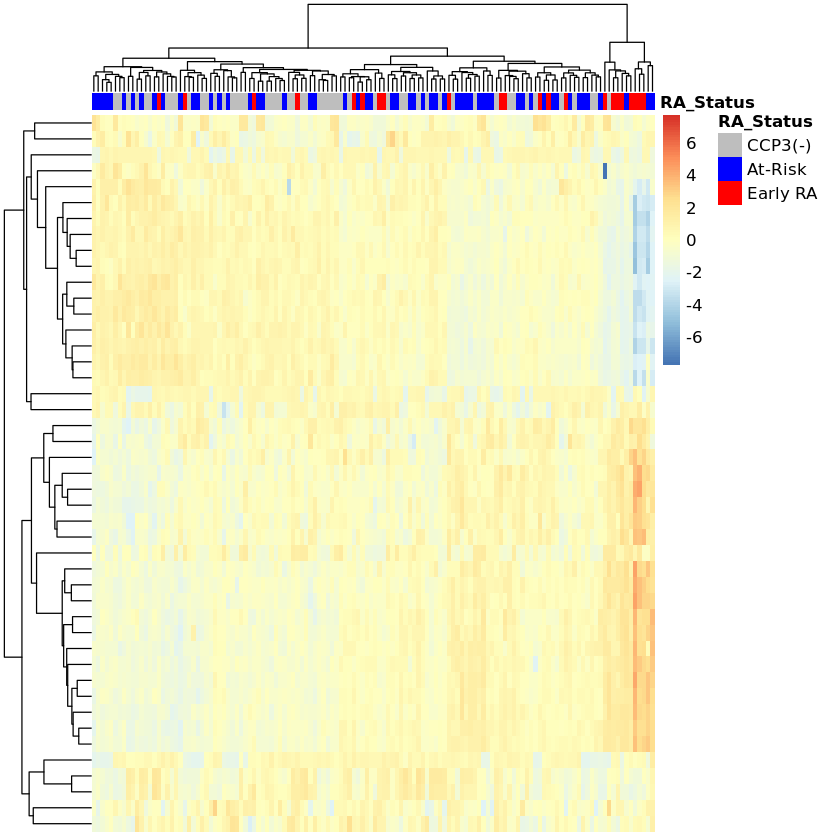

png 
  2

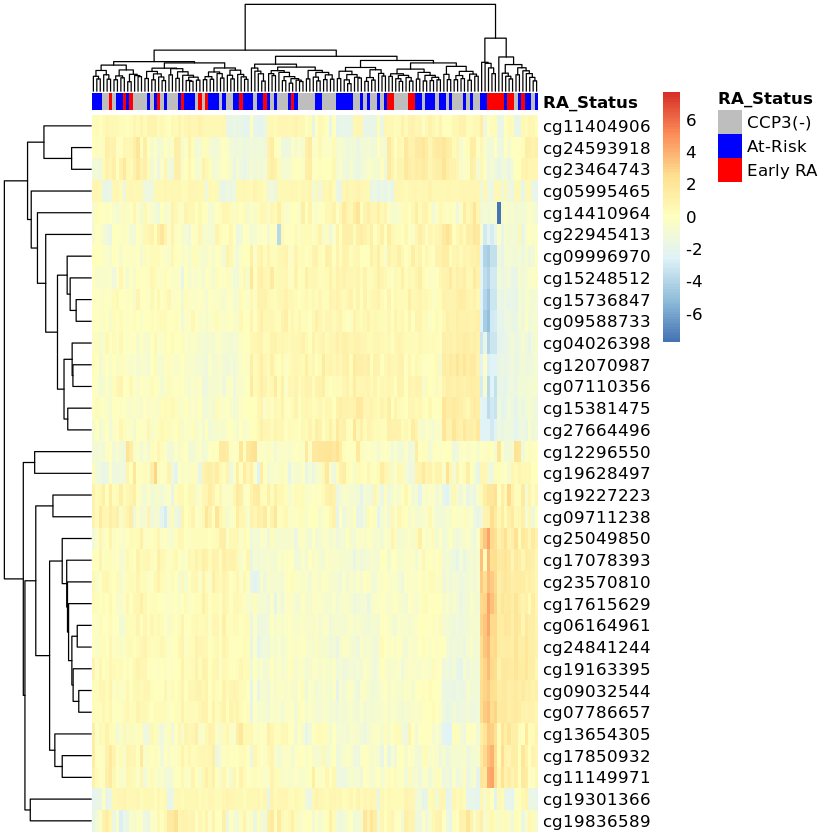

In [11]:
### Memory T Cell - DML Pathway Driver Heatmap Analysis ###
## Based on trends
adjPval_max = 1.0

# get dataframes
dmlDMGmatch_analysis_df = as.data.frame(read.delim(dmgUnion_tMem_dmlDMGmatch_fp, header = TRUE))


dmlDMGmatch_M_analysis_df = as.data.frame(read.delim(dmgUnion_tMem_dmlDMGmatch_M_fp, header = TRUE))
analysis_dmg_pathwaysHighlighted_df = tMem_dmg_pathwaysSelected_df[tMem_dmg_pathwaysSelected_df$Adj_Pval_FDR < adjPval_max, ]

# get driver DMLs
tMem_dmg_pathwaysHighlighted_df = tMem_dmg_pathwaysSelected_df[tMem_dmg_pathwaysSelected_df$Adj_Pval_FDR < adjPval_max, ]
analysis_sigDMGs_vector = unique(unlist(strsplit(tMem_dmg_pathwaysHighlighted_df$Gene.Symbol, split = "/")))
analysis_selDmlDMGmatch_vector = rownames(dmlDMGmatch_analysis_df[grep(paste(analysis_sigDMGs_vector, collapse="|"), dmlDMGmatch_analysis_df$DMG, value = FALSE), , drop = FALSE])

# create dataframe of M values with rows: analysis_selDmlDMGmatch_vector and cols: tMem only
selDmlDMGmatch_M_analysis_df = dmlDMGmatch_M_analysis_df[analysis_selDmlDMGmatch_vector, c(grep("_Tmem_CCPneg", colnames(dmlDMGmatch_M_analysis_df), value = TRUE),
                                                                                           grep("_Tmem_CCPpos", colnames(dmlDMGmatch_M_analysis_df), value = TRUE),
                                                                                           grep("_Tmem_ERA", colnames(dmlDMGmatch_M_analysis_df), value = TRUE))]

## Heatmap creation
# create input df
input_df = selDmlDMGmatch_M_analysis_df

# generate annotation df
cellType_vector = sapply(strsplit(colnames(input_df), "_"), '[', 3)
RAstatus_vector = sapply(strsplit(colnames(input_df), "_"), '[', 4)

annotation_df = data.frame(Cell_Type =  c("B Cell", "Mem T Cell", "Naive T Cell", cellType_vector)[match(cellType_vector, c("B", "Tmem", "Tnai", cellType_vector))],
                           RA_Status = c("CCP3(-)", "At-Risk", "Early RA", RAstatus_vector)[match(RAstatus_vector, c("CCPneg", "CCPpos", "ERA", RAstatus_vector))])
rownames(annotation_df) = colnames(input_df)

# create color scheme
ann_colors = list(RA_Status = c("CCP3(-)"="grey", "At-Risk"="blue", "Early RA"="red"),
                  Cell_Type = c("B Cell" = "#E95C20FF", "Mem T Cell" = "#006747FF", "Naive T Cell" = "#4F2C1DFF"))
# create heatmap
active_dml_hm = pheatmap(input_df, annotation_col = annotation_df[,c("RA_Status"), drop = FALSE],
                         scale="row",
                         cluster_cols = TRUE, cluster_rows = TRUE,
                         annotation_colors = ann_colors,
                         show_rownames = FALSE, show_colnames = FALSE,
                         fontsize = 10)

# output charts
png(paste0(reactome_output_dir,"/reactome_tMem_dmldmgTrend_hm.png"), width = 500, height = 500, units = "px")
active_dml_hm
dev.off()



## Based on significant
adjPval_max = 0.1

# get dataframes
dmlDMGmatch_analysis_df = as.data.frame(read.delim(dmgUnion_tMem_dmlDMGmatch_fp, header = TRUE))
dmlDMGmatch_M_analysis_df = as.data.frame(read.delim(dmgUnion_tMem_dmlDMGmatch_M_fp, header = TRUE))
analysis_dmg_pathwaysHighlighted_df = tMem_dmg_pathwaysSelected_df[tMem_dmg_pathwaysSelected_df$Adj_Pval_FDR < adjPval_max, ]

# get driver DMLs
tMem_dmg_pathwaysHighlighted_df = tMem_dmg_pathwaysSelected_df[tMem_dmg_pathwaysSelected_df$Adj_Pval_FDR < adjPval_max, ]
analysis_sigDMGs_vector = unique(unlist(strsplit(tMem_dmg_pathwaysHighlighted_df$Gene.Symbol, split = "/")))
analysis_selDmlDMGmatch_vector = rownames(dmlDMGmatch_analysis_df[grep(paste(analysis_sigDMGs_vector, collapse="|"), dmlDMGmatch_analysis_df$DMG, value = FALSE), , drop = FALSE])

# create dataframe of M values with rows: analysis_selDmlDMGmatch_vector and cols: tMem only
selDmlDMGmatch_M_analysis_df = dmlDMGmatch_M_analysis_df[analysis_selDmlDMGmatch_vector, c(grep("_Tmem_CCPneg", colnames(dmlDMGmatch_M_analysis_df), value = TRUE),
                                                                                           grep("_Tmem_CCPpos", colnames(dmlDMGmatch_M_analysis_df), value = TRUE),
                                                                                           grep("_Tmem_ERA", colnames(dmlDMGmatch_M_analysis_df), value = TRUE))]

## Heatmap creation
# create input df
input_df = selDmlDMGmatch_M_analysis_df

# generate annotation df
cellType_vector = sapply(strsplit(colnames(input_df), "_"), '[', 3)
RAstatus_vector = sapply(strsplit(colnames(input_df), "_"), '[', 4)

annotation_df = data.frame(Cell_Type =  c("B Cell", "Mem T Cell", "Naive T Cell", cellType_vector)[match(cellType_vector, c("B", "Tmem", "Tnai", cellType_vector))],
                           RA_Status = c("CCP3(-)", "At-Risk", "Early RA", RAstatus_vector)[match(RAstatus_vector, c("CCPneg", "CCPpos", "ERA", RAstatus_vector))])
rownames(annotation_df) = colnames(input_df)

# create color scheme
ann_colors = list(RA_Status = c("CCP3(-)"="grey", "At-Risk"="blue", "Early RA"="red"),
                  Cell_Type = c("B Cell" = "#E95C20FF", "Mem T Cell" = "#006747FF", "Naive T Cell" = "#4F2C1DFF"))
# create heatmap
active_dml_hm = pheatmap(input_df, annotation_col = annotation_df[,c("RA_Status"), drop = FALSE],
                         scale="row",
                         cluster_cols = TRUE, cluster_rows = TRUE,
                         annotation_colors = ann_colors,
                         show_rownames = TRUE, show_colnames = FALSE,
                         fontsize = 10)

# output charts
png(paste0(reactome_output_dir,"/reactome_tMem_dmldmgSig_hm.png"), width = 500, height = 500, units = "px")
active_dml_hm
dev.off()